# Building a Fashion MNIST Classifier with PyTorch

Welcome to this comprehensive tutorial where we'll build a convolutional neural network (CNN) to classify fashion items from the Fashion MNIST dataset. This notebook builds upon our previous understanding of basic neural networks and introduces proper data handling with PyTorch's Dataset and DataLoader classes.

## 1. Setting Up Our Environment

First, let's import all the necessary libraries we'll need for this project.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Let's also check if we have GPU available for training:

In [4]:
def check_mps_available():
  if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
      print("MPS not available because PyTorch was not built with MPS enabled"
          )
    else:
      print("MPS not available because the current MacOS version is not 12.3+ and /or you do not have an MPS-enabled device")
      
    return False
  return True

def get_device():
  if check_mps_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device
  
device = get_device()

Using MPS (Apple Silicon GPU)


## 2. Understanding the Fashion MNIST Dataset

The Fashion MNIST dataset consists of 70,000 grayscale images of clothing items, each 28x28 pixels. There are 10 different classes of clothing items. Let's explore this dataset.

In [5]:
"""
# Define our data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load training and test datasets
train_dataset = datasets.FashionMNIST(
    root='data', 
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='data', 
    train=False,
    download=True,
    transform=transform
)
"""


Trying with Data Augmentation to gte better generalisation 

In [26]:
# Define separate transformations for training (with augmentation) and testing

transform_train = transforms.Compose([
    transforms.RandomRotation(10),          # Randomly rotate images by up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Randomly shift images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))       # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets with the respective transforms
train_dataset = datasets.FashionMNIST(
    root='data', 
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.FashionMNIST(
    root='data', 
    train=False,
    download=True,
    transform=transform_test
)


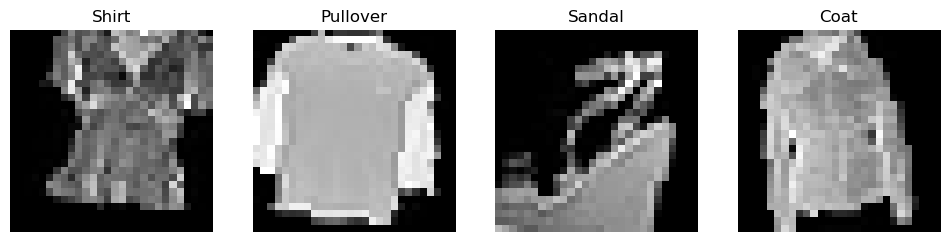

In [27]:
def show_fashion_mnist(images, labels):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    fig = plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(train_dataset, batch_size=4, shuffle=True))
images, labels = next(dataiter)
show_fashion_mnist(images, labels)

## 3. Creating Our Model Architecture

Now, let's build our CNN model. We'll create a more sophisticated architecture than our previous simple neural network, specifically designed for image classification.

Let's visualize some samples from our dataset:

In [28]:
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Pooling and Dropout layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # First conv block: Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Second conv block: Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Flatten the feature maps
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers with dropout
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Let's understand why this architecture is more suitable for our task:

1. **Convolutional Layers**: Unlike our previous fully connected network, we now use convolutional layers that are specifically designed to detect patterns in images. The first layer detects simple features like edges, while deeper layers can detect more complex patterns.

2. **Batch Normalization**: We've added batch normalization after each convolutional layer to help with training stability and reduce the internal covariate shift.

3. **Max Pooling**: This helps reduce the spatial dimensions while keeping the most important features, making our network more efficient and helping it focus on what's important in the images.

4. **Dropout**: We've added dropout layers to prevent overfitting, randomly "dropping" some neurons during training to make our network more robust.

## 4. Setting Up the Training Pipeline

Now let's create our data loaders and set up our training configuration:

In [29]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize the model, loss function, and optimizer
model = FashionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## 5. Training the Model

Let's create a training function that will also track our progress:

In [30]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Print progress every 100 batches
        if batch_idx % 100 == 99:
            print(f'Batch [{batch_idx + 1}/{len(train_loader)}] | '
                  f'Loss: {running_loss/100:.4f} | '
                  f'Accuracy: {100.*correct/total:.2f}%')
            running_loss = 0.0
    
    return correct/total

# Train for multiple epochs
num_epochs = 10
train_accuracy = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_accuracy.append(acc)


Epoch 1/10
Batch [100/938] | Loss: 0.9772 | Accuracy: 63.66%
Batch [200/938] | Loss: 0.7079 | Accuracy: 68.15%
Batch [300/938] | Loss: 0.6704 | Accuracy: 70.26%
Batch [400/938] | Loss: 0.5869 | Accuracy: 72.30%
Batch [500/938] | Loss: 0.5790 | Accuracy: 73.45%
Batch [600/938] | Loss: 0.5572 | Accuracy: 74.41%
Batch [700/938] | Loss: 0.5444 | Accuracy: 75.15%
Batch [800/938] | Loss: 0.5354 | Accuracy: 75.75%
Batch [900/938] | Loss: 0.5088 | Accuracy: 76.39%

Epoch 2/10
Batch [100/938] | Loss: 0.4920 | Accuracy: 82.00%
Batch [200/938] | Loss: 0.5018 | Accuracy: 81.59%
Batch [300/938] | Loss: 0.4878 | Accuracy: 81.57%
Batch [400/938] | Loss: 0.4858 | Accuracy: 81.52%
Batch [500/938] | Loss: 0.4598 | Accuracy: 81.76%
Batch [600/938] | Loss: 0.4846 | Accuracy: 81.80%
Batch [700/938] | Loss: 0.4807 | Accuracy: 81.86%
Batch [800/938] | Loss: 0.4760 | Accuracy: 81.87%
Batch [900/938] | Loss: 0.4585 | Accuracy: 82.02%

Epoch 3/10
Batch [100/938] | Loss: 0.4525 | Accuracy: 82.84%
Batch [200/938


## 6. Evaluating Our Model

After training, let's evaluate our model's performance:

In [31]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Overall accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Per-class accuracy
            c = predicted.eq(labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # Print results
    print(f'\nOverall Test Accuracy: {100.*correct/total:.2f}%')
    
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    print('\nPer-class Accuracy:')
    for i in range(10):
        print(f'{class_names[i]}: {100.*class_correct[i]/class_total[i]:.2f}%')

# Evaluate the model
evaluate(model, test_loader, device)


Overall Test Accuracy: 90.70%

Per-class Accuracy:
T-shirt/top: 86.80%
Trouser: 98.60%
Pullover: 83.90%
Dress: 91.80%
Coat: 88.70%
Sandal: 96.40%
Shirt: 69.00%
Sneaker: 98.00%
Bag: 98.00%
Ankle boot: 95.80%


## 7. Visualizing Results

Let's create some visualizations to better understand our model's performance:

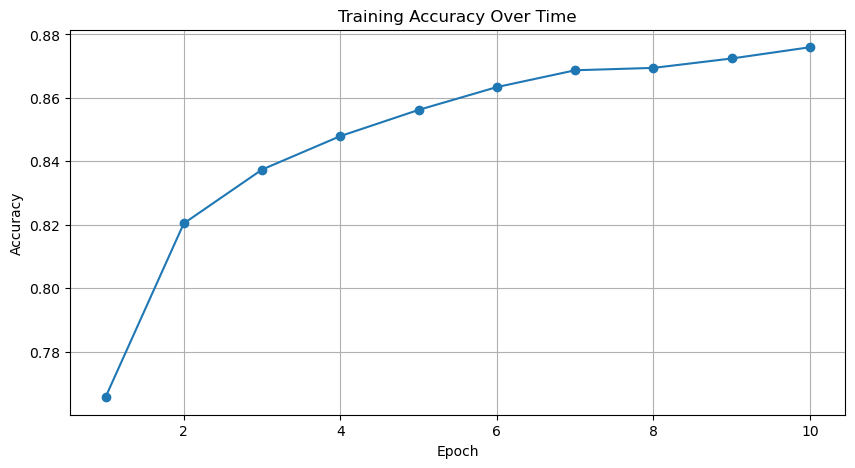

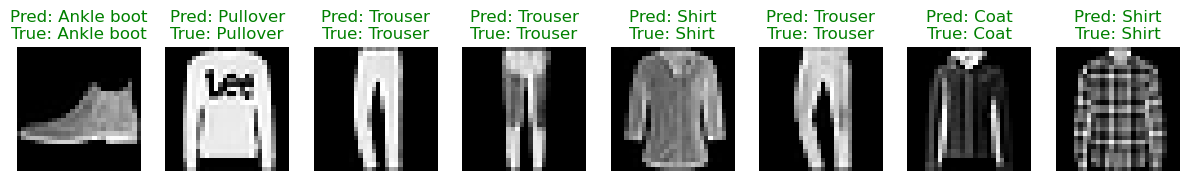

In [32]:
# Plot training accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy, marker='o')
plt.title('Training Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Visualize some predictions
def show_predictions(model, test_loader, device, num_images=8):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_images].to(device)
    labels = labels[:num_images]
    
    outputs = model(images)
    _, predicted = outputs.max(1)
    
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    fig = plt.figure(figsize=(15, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}',
                 color=color)
        plt.axis('off')
    plt.show()

show_predictions(model, test_loader, device)

## 8. Saving and Loading the Model

Finally, let's save our trained model so we can use it later:

In [33]:
# Save the model
torch.save(model.state_dict(), 'models/fashion_mnist_model_augmentation.pth')

# To load the model later:
# model = FashionClassifier()
# model.load_state_dict(torch.load('models/fashion_mnist_model.pth'))

## Conclusion

In this tutorial, we've built a complete image classification pipeline using PyTorch's Dataset and DataLoader classes. Our CNN architecture demonstrates several important deep learning concepts:

1. Proper data handling with DataLoader
2. Convolutional neural network architecture
3. Training with batch processing
4. Model evaluation and visualization
5. Model persistence

This represents a significant improvement over our previous simple neural network, particularly in how we handle the data and in the sophistication of our model architecture.



# PyTorch Functions and Classes: 

## Neural Network Building Blocks (torch.nn)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `nn.Module` | Base class for neural networks | Provides the foundation for creating our custom CNN model with automatic gradient computation |
| `nn.Conv2d` | 2D convolutional layer | Enables our model to detect spatial patterns in images like edges, textures, and shapes |
| `nn.BatchNorm2d` | 2D batch normalization | Stabilizes training by normalizing layer inputs, allowing faster and more stable learning |
| `nn.MaxPool2d` | 2D max pooling | Reduces spatial dimensions while preserving important features, making computation more efficient |
| `nn.Linear` | Fully connected layer | Combines high-level features for final classification decisions |
| `nn.Dropout` | Dropout regularization | Prevents overfitting by randomly deactivating neurons during training |
| `nn.ReLU` | Rectified Linear Unit | Introduces non-linearity in our model, enabling it to learn complex patterns |

## Data Handling (torch.utils.data)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `DataLoader` | Data loading utility | Handles batch creation, shuffling, and parallel data loading for efficient training |
| `Dataset` | Abstract dataset class | Base class for creating custom datasets with standardized access patterns |
| `datasets.FashionMNIST` | Fashion MNIST dataset | Provides our training and testing data in a standardized format |

## Model Operations (torch.nn.functional as F)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `F.linear` | Linear transformation | Performs the actual computation in linear layers |
| `F.relu` | ReLU activation | Applies non-linear activation in our forward passes |
| `F.cross_entropy` | Loss function | Combines softmax activation and negative log likelihood loss for classification |

## Model Management (torch)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `torch.save` | Save model state | Stores trained model parameters for later use |
| `torch.load` | Load model state | Retrieves saved model parameters |
| `torch.no_grad()` | Disable gradients | Improves memory efficiency during evaluation and inference |
| `torch.manual_seed` | Set random seed | Ensures reproducibility of our results |
| `torch.device` | Device specification | Manages CPU/GPU computation |

## Data Transformation (torchvision.transforms)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `transforms.ToTensor()` | Convert to tensor | Transforms PIL images to PyTorch tensors |
| `transforms.Normalize()` | Normalize data | Standardizes input data for better training stability |
| `transforms.Compose` | Combine transforms | Chains multiple transformations into a single transform |

## Optimization (torch.optim)

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `optim.Adam` | Adam optimizer | Efficiently updates model parameters during training with adaptive learning rates |
| `optim.zero_grad()` | Reset gradients | Clears accumulated gradients before each backward pass |
| `backward()` | Backpropagation | Computes gradients for parameter updates |
| `step()` | Parameter update | Applies computed gradients to update model parameters |

## Tensor Operations

| Function/Class | Purpose | Why We Used It |
|---------------|---------|----------------|
| `view()` | Reshape tensor | Restructures tensors between convolutional and linear layers |
| `squeeze()` | Remove dimensions | Eliminates unnecessary single dimensions from tensors |
| `to(device)` | Move to device | Transfers tensors between CPU and GPU |
| `numpy()` | Convert to numpy | Converts PyTorch tensors to numpy arrays for visualization |

## Key Implementation Patterns

1. **Model Definition Pattern**:
```python
class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
    
    def forward(self, x):
        # Define forward pass
```

2. **Training Loop Pattern**:
```python
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
```

3. **Evaluation Pattern**:
```python
with torch.no_grad():
    model.eval()
    # Perform evaluation
```

This organization helps us understand not just what PyTorch functions we used, but how they work together to create a complete deep learning pipeline. Each component plays a specific role in either building the model architecture, managing data flow, or facilitating the training process.

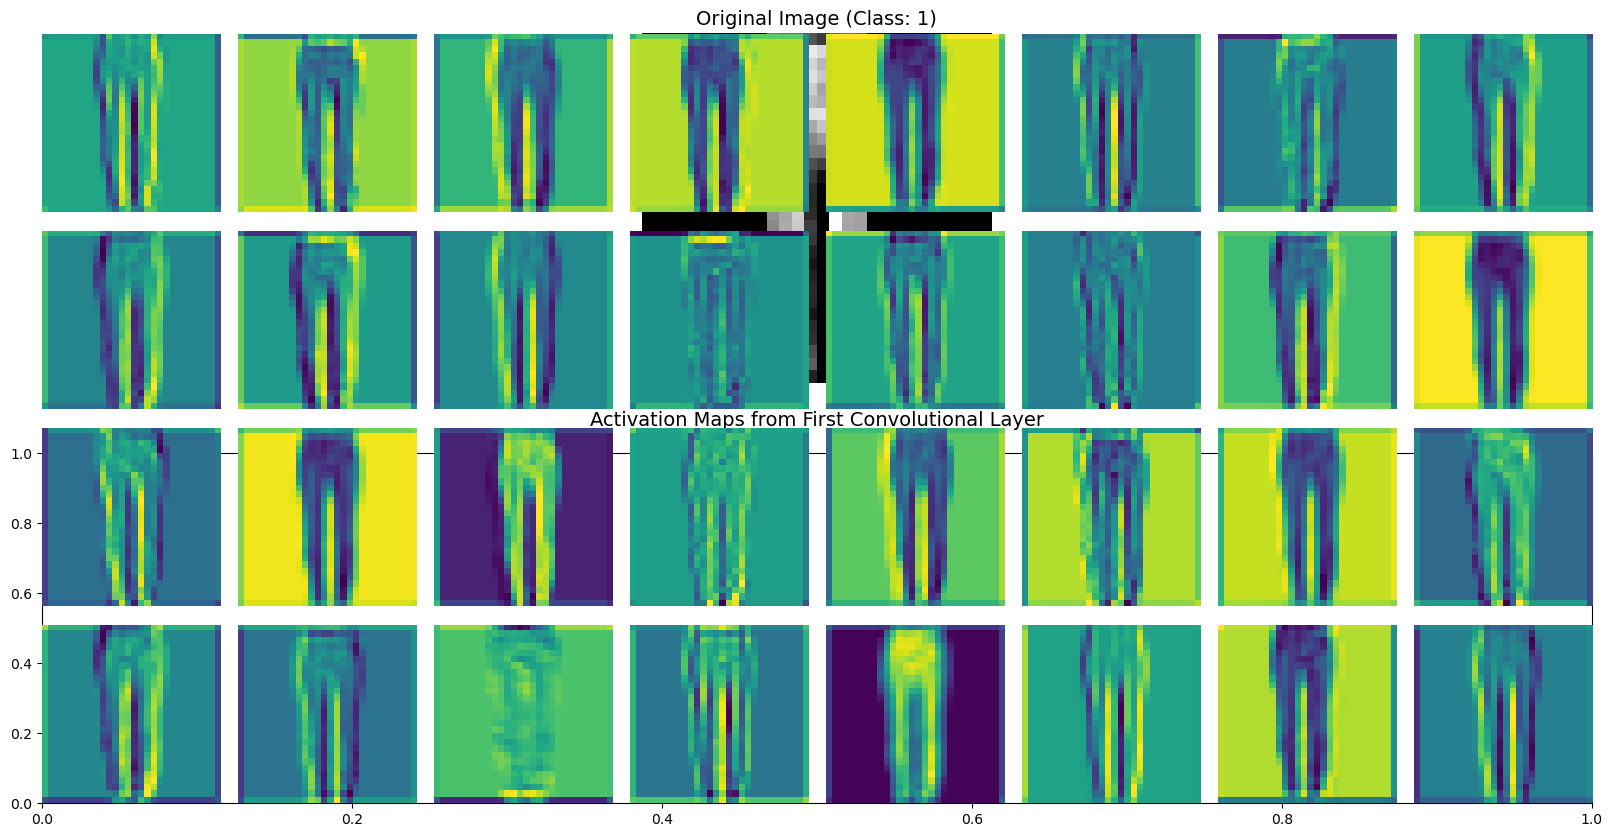

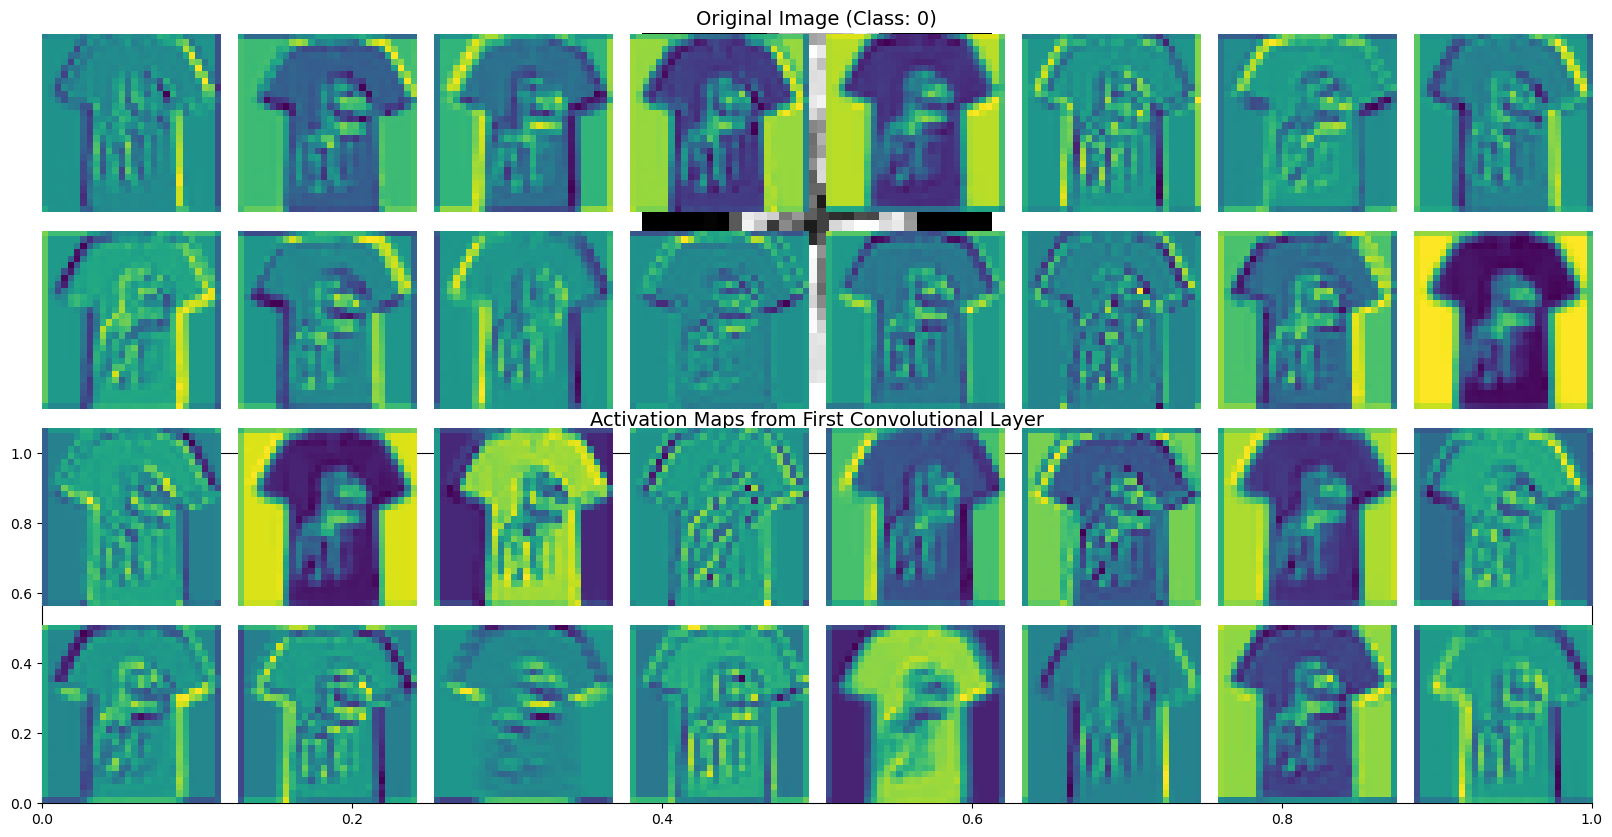

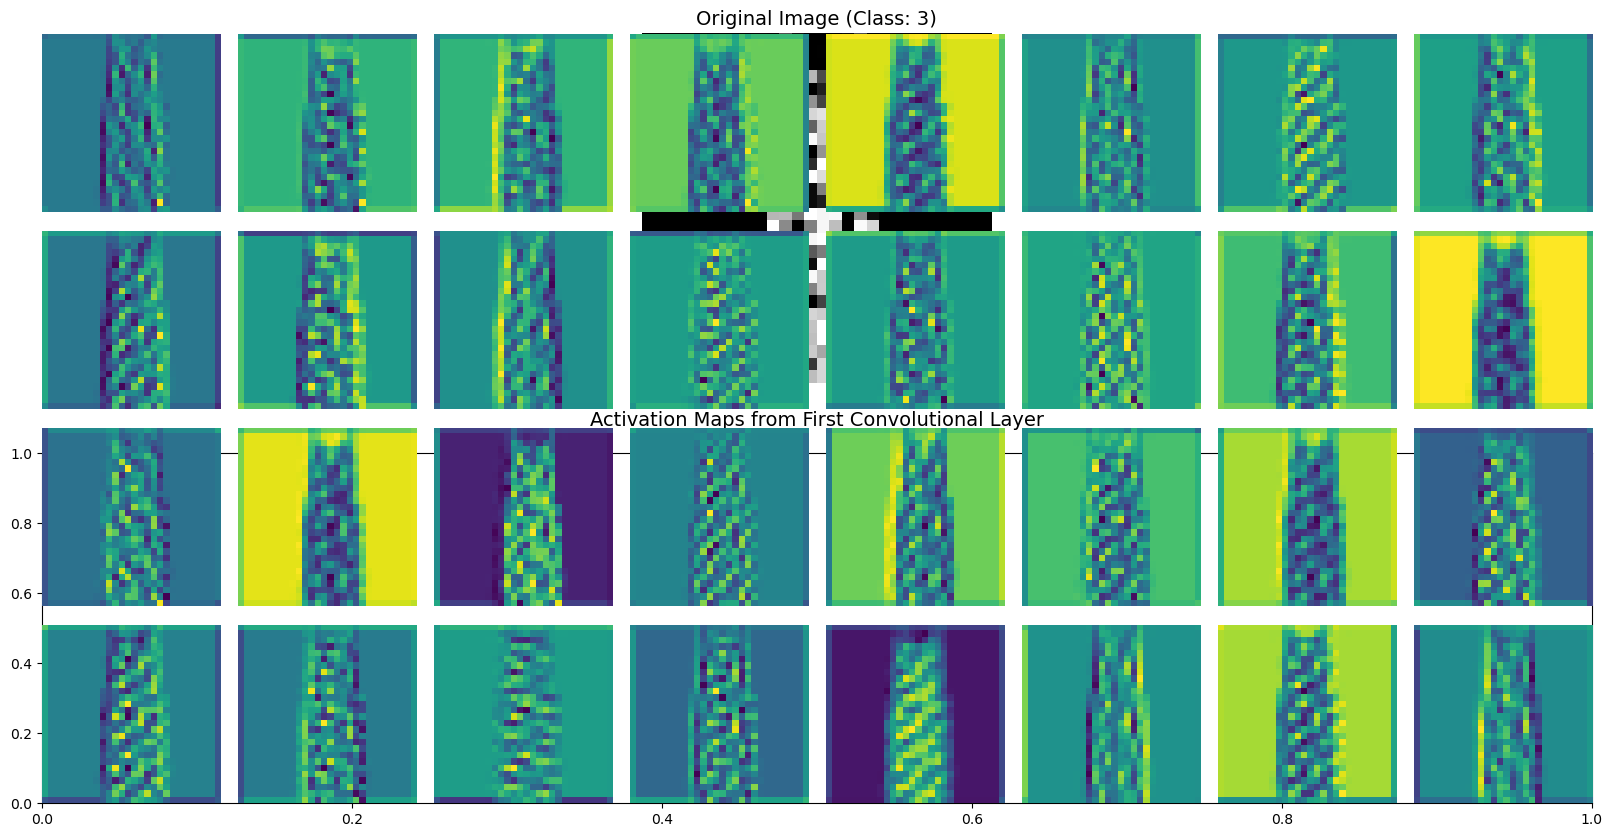

In [34]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

def visualize_activation_maps(model, test_loader, num_images=3):
    """
    Visualizes activation maps from the first convolutional layer for multiple images.
    This helps us understand what features the CNN is detecting.
    
    Args:
        model: Our trained CNN model
        test_loader: DataLoader containing test images
        num_images: Number of different images to visualize
    """
    # Set model to evaluation mode
    model.eval()
    
    # Store activations from conv1 layer
    activations = {}
    
    # Define a hook function that will capture the output of conv1 layer
    def hook(model, input, output):
        # Store the output (activations) when the layer is executed
        activations['conv1'] = output.detach()
    
    # Register our hook to the first convolutional layer
    hook_handle = model.conv1.register_forward_hook(hook)
    
    # Get a batch of images
    images, labels = next(iter(test_loader))
    
    # Process multiple images
    for img_idx in range(num_images):
        # Get a single image and add batch dimension
        image = images[img_idx:img_idx+1]
        label = labels[img_idx]
        
        # Create a figure with two rows
        fig = plt.figure(figsize=(20, 10))
        
        # Plot the original image
        plt.subplot(2, 1, 1)
        plt.imshow(image.squeeze().cpu(), cmap='gray')
        plt.title(f'Original Image (Class: {label})', fontsize=14)
        plt.axis('off')
        
        # Forward pass to get activations
        with torch.no_grad():
            output = model(image)
        
        # Get the activation maps from conv1 layer
        act = activations['conv1'].squeeze()
        
        # Create a grid of activation maps
        plt.subplot(2, 1, 2)
        activation_grid = plt.GridSpec(4, 8, wspace=0.1, hspace=0.1)
        plt.title('Activation Maps from First Convolutional Layer', fontsize=14, pad=20)
        
        # Plot each activation channel
        for i in range(32):  # We have 32 channels in conv1
            row = i // 8
            col = i % 8
            plt.subplot(activation_grid[row, col])
            plt.imshow(act[i].cpu(), cmap='viridis')
            plt.axis('off')
        
        plt.show()
    
    # Remove the hook
    hook_handle.remove()

# Let's use our function with some test images
def analyze_model_activations(model_path='models/fashion_mnist_model_augmentation.pth'):
    # Load the model if it's not already loaded
    if isinstance(model_path, str):
        model = FashionClassifier()
        model.load_state_dict(torch.load(model_path))
    else:
        model = model_path
    
    # Prepare the data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_dataset = datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=transform
    )
    
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    # Visualize activations for multiple images
    visualize_activation_maps(model, test_loader, num_images=3)

# Call the analysis function
analyze_model_activations()

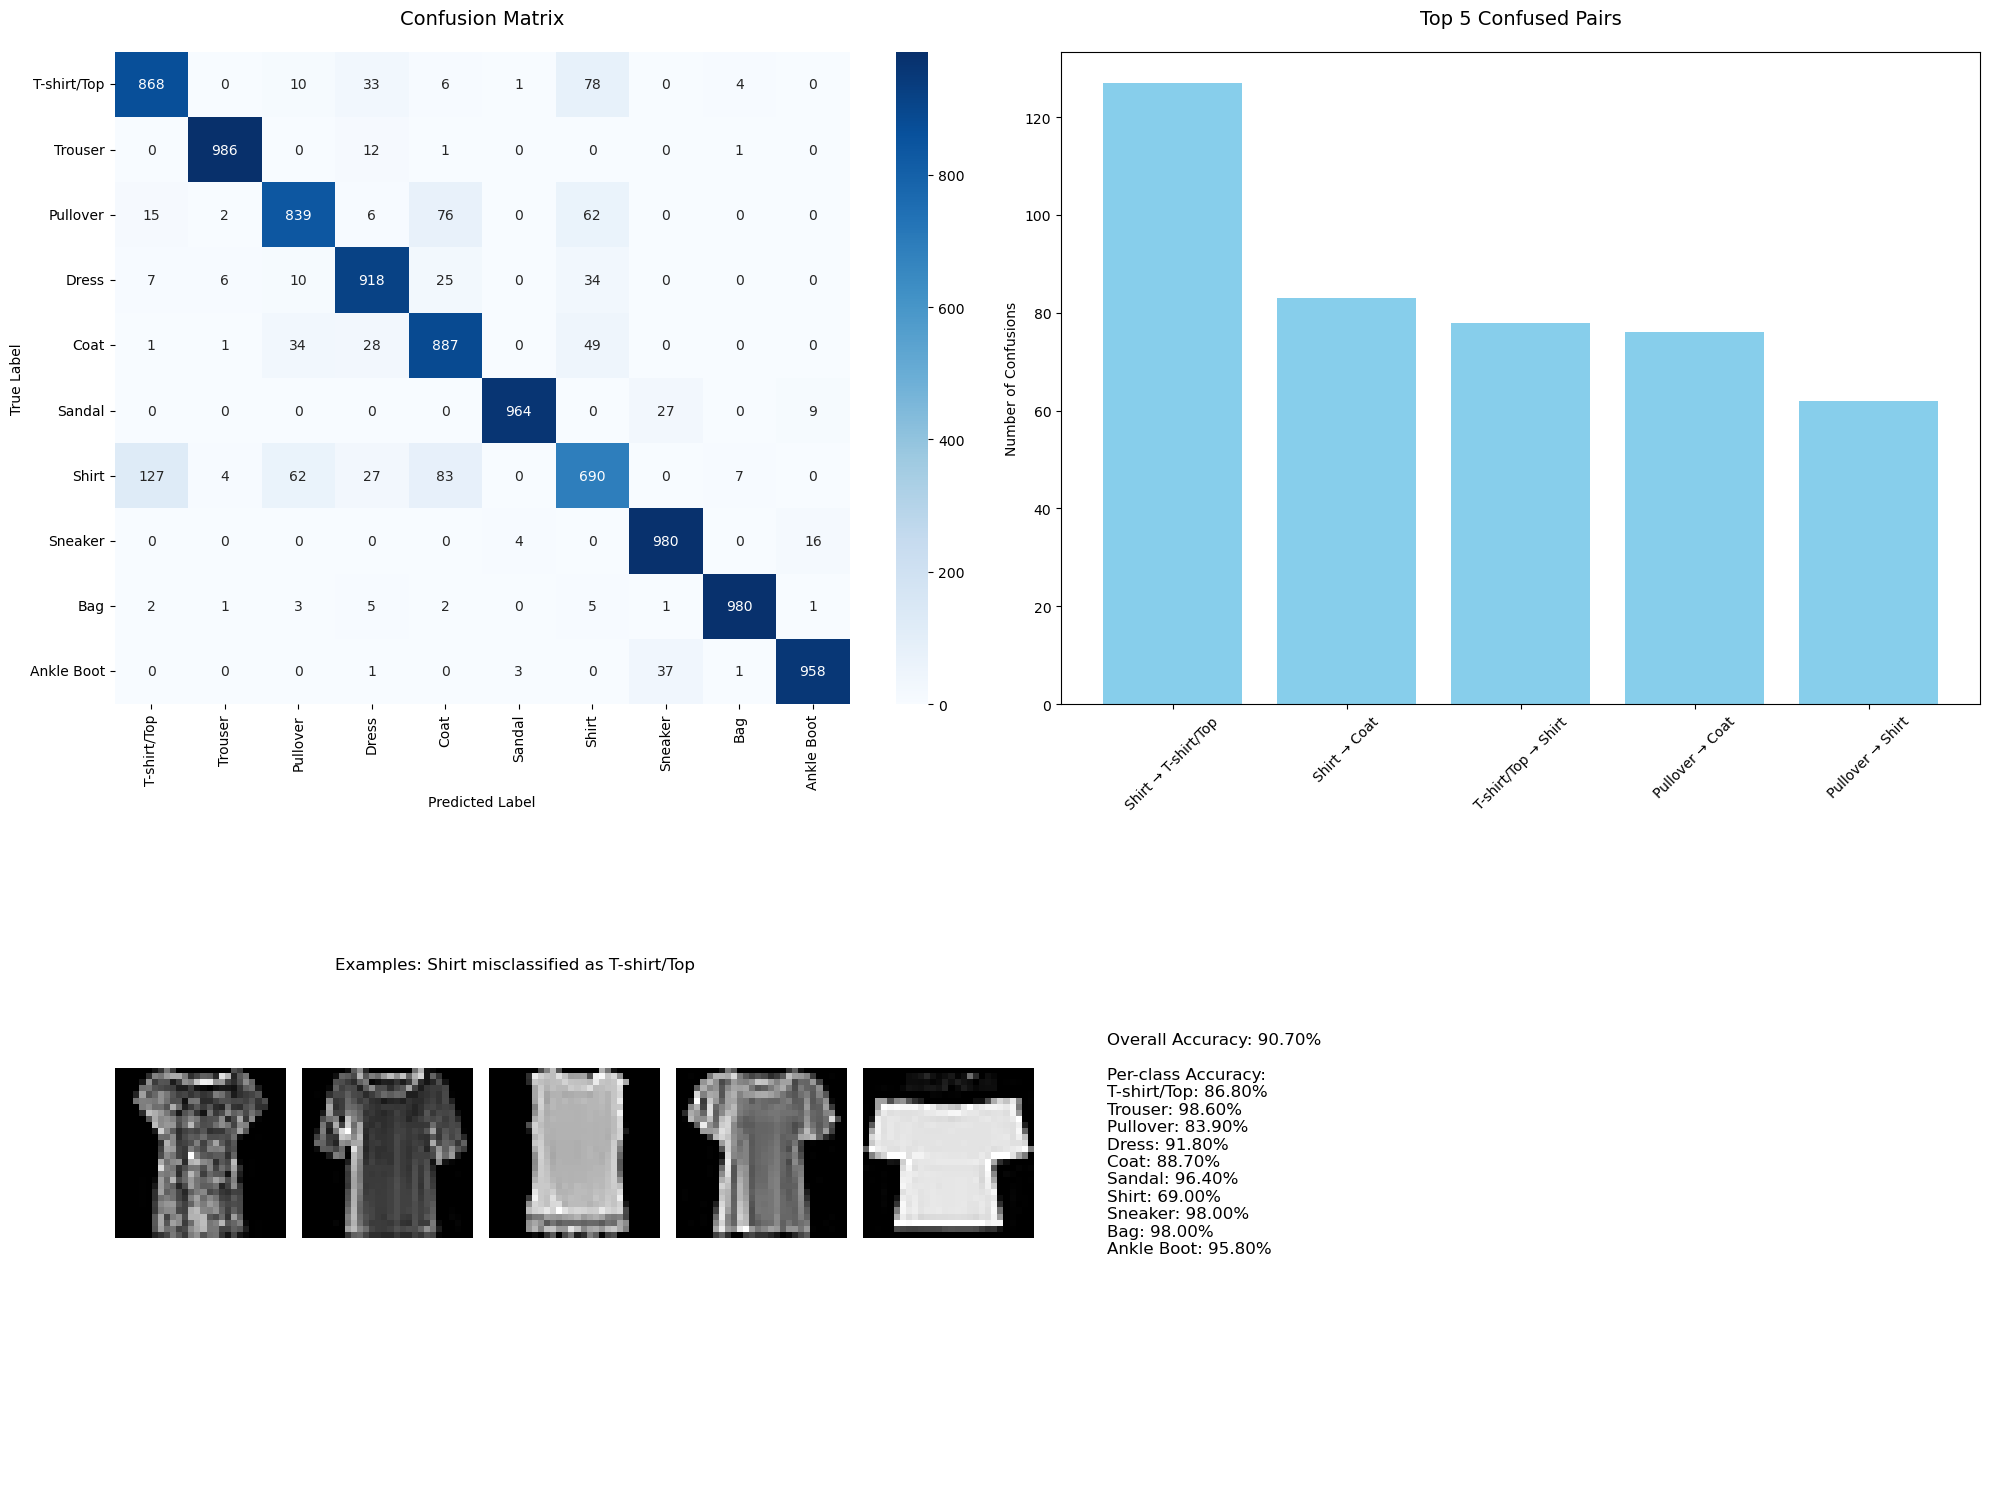


Top 5 Most Confused Pairs:
1. Shirt mistaken as T-shirt/Top: 127 times
2. Shirt mistaken as Coat: 83 times
3. T-shirt/Top mistaken as Shirt: 78 times
4. Pullover mistaken as Coat: 76 times
5. Pullover mistaken as Shirt: 62 times


In [35]:

import matplotlib.gridspec as gridspec

def analyze_confusions_detailed(model, test_loader, class_names, max_examples=5):
    """
    Analyzes model confusions and visualizes:
      - Confusion matrix heatmap
      - Bar chart of top confused pairs
      - Example misclassifications for the most confused pair
      - Additional confusion statistics

    Args:
        model: Trained model.
        test_loader: DataLoader for test data.
        class_names: List of class names.
        max_examples: Maximum number of misclassified examples to store per confused pair.
        
    Returns:
        confused_pairs: List of tuples (true_class, predicted_class, count) sorted by count.
        confusion_matrix: NumPy array of shape (num_classes, num_classes).
    """
    num_classes = len(class_names)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    confused_examples = {}

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = outputs.max(1)
            for true, pred, img in zip(labels, preds, images):
                true_idx, pred_idx = true.item(), pred.item()
                confusion_matrix[true_idx, pred_idx] += 1
                if true_idx != pred_idx:
                    confused_examples.setdefault((true_idx, pred_idx), [])
                    if len(confused_examples[(true_idx, pred_idx)]) < max_examples:
                        confused_examples[(true_idx, pred_idx)].append(img)

    # Create list of confused pairs (excluding correct predictions)
    confused_pairs = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                confused_pairs.append((i, j, confusion_matrix[i, j]))
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    # Visualization using GridSpec layout
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(2, 2, figure=fig)

    # 1. Confusion Matrix Heatmap
    ax_conf = fig.add_subplot(gs[0, 0])
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax_conf)
    ax_conf.set_title('Confusion Matrix', fontsize=14, pad=20)
    ax_conf.set_xlabel('Predicted Label')
    ax_conf.set_ylabel('True Label')

    # 2. Bar Chart for Top 5 Confused Pairs
    ax_bar = fig.add_subplot(gs[0, 1])
    top_5_pairs = confused_pairs[:5]
    pair_labels = [f"{class_names[i]} → {class_names[j]}" for i, j, _ in top_5_pairs]
    confusion_counts = [count for _, _, count in top_5_pairs]
    ax_bar.bar(pair_labels, confusion_counts, color='skyblue')
    ax_bar.set_title('Top 5 Confused Pairs', fontsize=14, pad=20)
    ax_bar.set_ylabel('Number of Confusions')
    ax_bar.tick_params(axis='x', rotation=45)

    # 3. Display Examples for the Most Confused Pair
    top_pair = confused_pairs[0]
    true_class, pred_class = top_pair[0], top_pair[1]
    examples = confused_examples.get((true_class, pred_class), [])
    # Create a subgrid for example images within the corresponding GridSpec cell
    gs_img = gridspec.GridSpecFromSubplotSpec(1, max_examples, subplot_spec=gs[1, 0], wspace=0.1)
    for i in range(max_examples):
        ax_img = fig.add_subplot(gs_img[0, i])
        if i < len(examples):
            ax_img.imshow(examples[i].squeeze(), cmap='gray')
        ax_img.axis('off')
    # Add a title to the entire cell (using a text annotation)
    fig.text(0.26, 0.35, f"Examples: {class_names[true_class]} misclassified as {class_names[pred_class]}",
             fontsize=12, ha='center')

    # 4. Display Additional Statistics
    ax_stats = fig.add_subplot(gs[1, 1])
    ax_stats.axis('off')
    stats_text = generate_confusion_statistics(confusion_matrix, class_names)
    ax_stats.text(0.05, 0.5, stats_text, fontsize=12, va='center')
    
    plt.tight_layout()
    plt.show()
    
    return confused_pairs, confusion_matrix

def generate_confusion_statistics(confusion_matrix, class_names):
    """
    Generates statistics for confusion analysis including overall and per-class accuracy.
    """
    total = confusion_matrix.sum()
    correct = np.trace(confusion_matrix)
    overall_accuracy = (correct / total) * 100 if total > 0 else 0.0

    stats = f"Overall Accuracy: {overall_accuracy:.2f}%\n\nPer-class Accuracy:\n"
    for i, name in enumerate(class_names):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        class_accuracy = (class_correct / class_total * 100) if class_total > 0 else 0.0
        stats += f"{name}: {class_accuracy:.2f}%\n"
    return stats

# Define class names for Fashion MNIST
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def run_confusion_analysis(model_path='models/fashion_mnist_model_augmentation.pth'):
    """
    Loads the trained model and test data, then runs the confusion analysis visualization.
    """
    # Assume FashionClassifier is defined elsewhere in your codebase.
    model = FashionClassifier()  # Replace with your model class
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Data transformation and dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    confused_pairs, confusion_matrix = analyze_confusions_detailed(model, test_loader, class_names)
    
    print("\nTop 5 Most Confused Pairs:")
    for i, (true_idx, pred_idx, count) in enumerate(confused_pairs[:5], 1):
        print(f"{i}. {class_names[true_idx]} mistaken as {class_names[pred_idx]}: {count} times")

# Uncomment the following line to run the analysis:
run_confusion_analysis()
